# Model Training 
This is the code is the training code for ML-based approach in intrusion detection. It was modified from notebook provided by "[**Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection**](https://arxiv.org/pdf/2409.03141)".

Please also cite:
L. Yang and A. Shami, “Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection,” in Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber ’24), 2024 ACM SIGSAC Conference on Computer and Communications Security (CCS’24), 2024, pp. 1–11. doi: 10.1145/3689933.3690833.

```
@INPROCEEDINGS{3690833,
  author={Yang, Li and Shami, Abdallah},
  title = {Towards Autonomous Cybersecurity: An Intelligent AutoML Framework for Autonomous Intrusion Detection},
  booktitle = {Proceedings of the Workshop on Autonomous Cybersecurity (AutonomousCyber '24), ACM Conference on Computer and Communications Security (CCS) 2024},
  year = {2024},
  address = {Salt Lake City, UT, USA},
  pages = {1-11},
  doi = {10.1145/3689933.3690833}
}
```

## Import libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import catboost as cb
import time

In [5]:
CHECKPOINT_OUTPUT = "./models2"

## Dataset 1: CICIDS2017
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  

Due to the large size of this dataset and the file size limit of GitHub, the sampled subset of CICIDS2017 is used. The subsets are in the "Data" folder.  PS: The results might be different from the paper due to the size difference of the dataset.

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.


### Load data

In [3]:
# Read the dataset
df = pd.read_csv('../../datasets/output/train_final.csv', parse_dates=['Timestamp'])

In [ ]:
df = df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp', 'Old Index', 'Total Connection Flow Time'], axis=1)

### Data pre-processing

In [9]:
# Encode the dataset
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Label'])

In [10]:
df['Label'].value_counts()

Label
0    485184
1    127232
2      4565
Name: count, dtype: int64

In [12]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Benign', 'Portscan', 'Slowloris'])

array([0, 1, 2])

In [12]:
df.isnull().any().any()

False

In [13]:
df.isna().any().any()

False

In [14]:
# Split the dataset into training and testing
X = df.drop(['Label'],axis=1) 
y = df['Label'].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_val, y_train, y_val = train_test_split(X,y, train_size = 0.75, test_size = 0.25, random_state = 0, stratify = y)
# 0.75 & 0.25 means 60% train and 20% validation FROM WHOLE DATASET (counting test)

In [15]:
labelencoder.classes_

array(['Benign', 'Portscan', 'Slowloris'], dtype=object)

## Data Balancing by Proposed TVAE-based Method

In [16]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [17]:
y_train = pd.Series(y_train)
y_val = pd.Series(y_val)

In [18]:
from sdv.single_table import TVAESynthesizer
# Identify the average number of samples per class
average_samples = y_train.value_counts().mean()

# Identify minority classes with less than half the average number of samples
minority_classes = y_train.value_counts()
minority_classes = minority_classes[minority_classes < average_samples / 2].index.tolist()

# Prepare an empty DataFrame to collect synthetic data
synthetic_data = pd.DataFrame()

In [19]:
y_train.index = X_train.index

In [21]:
# Generating synthetic samples for each minority class using TVAE
for cls in minority_classes:
    cls_samples = X_train[y_train == cls]
    num_samples_needed = int(average_samples - len(cls_samples))
    
    # Initialize the TVAE model with detected metadata
    tvaegan = TVAESynthesizer(metadata=metadata, cuda=True, verbose=True)
    
    # Fit the TVAE model on the minority class samples
    tvaegan.fit(cls_samples.assign(Label=y_train[y_train == cls]))  # add Label temporarily for TVAE training
    
    # Generate synthetic instances to match the average class sample size
    new_samples = tvaegan.sample(num_samples_needed)
    
    # Append the new synthetic instances to the synthetic data list
    synthetic_data = pd.concat([synthetic_data, new_samples], ignore_index=True)

Loss: -460.718: 100%|██████████| 300/300 [01:06<00:00,  4.54it/s]


In [22]:
# Concatenate the original and synthetic data to form a balanced dataset
balanced_data = pd.concat([X_train.assign(Label=y_train), synthetic_data], ignore_index=True)

# Display the new distribution of labels in the balanced dataset
print(balanced_data['Label'].value_counts())

# Prepare the balanced dataset for model training
X_train_balanced = balanced_data.drop(['Label'], axis=1)
y_train_balanced = balanced_data['Label']

Label
0    363887
2    154245
1     95424
Name: count, dtype: int64


In [35]:
X_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index=False)
X_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv", index=False)
y_val.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index=False)
y_train_balanced.to_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv", index=False)

In [6]:
X_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_val.csv", index_col=0)
X_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/X_train_balanced.csv")
y_val = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_val.csv", index_col=0)['0']
y_train_balanced = pd.read_csv(f"{CHECKPOINT_OUTPUT}/y_train_balanced.csv")['Label']

## Machine learning model training (for feature selection)

### Training six base learners (for comparison purposes): 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

#### DT

Training time:  24.12616491317749
Prediction time per sample:  0.00021048308009281972
Cross-Validation scores:  [0.99770193 0.99992666 0.99992177]
Mean of Cross-Validation scores:  0.9991834498209086
Accuracy of DT: 0.9999157190461989
Precision of DT: 0.9999157750383243
Recall of DT: 0.9999157190461989
F1-score of DT: 0.9999157413257667
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



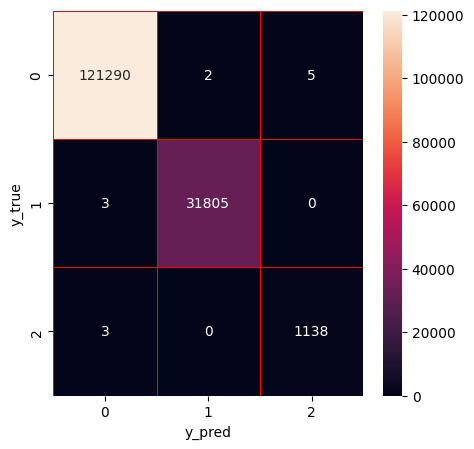

In [7]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_balanced, y_train_balanced, cv=3, n_jobs=4)

# calculate the training time
start = time.time()
dt.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### RF

Training time:  25.199129581451416
Prediction time:  0.0012685001099713865 ms
Cross-Validation scores:  [0.99990221 0.99999511 0.99999022]
Mean of Cross-Validation scores:  0.9999625136543481
Accuracy of RF: 0.999967584248538
Precision of RF: 0.999967584686077
Recall of RF: 0.999967584248538
F1-score of RF: 0.9999675786091253
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



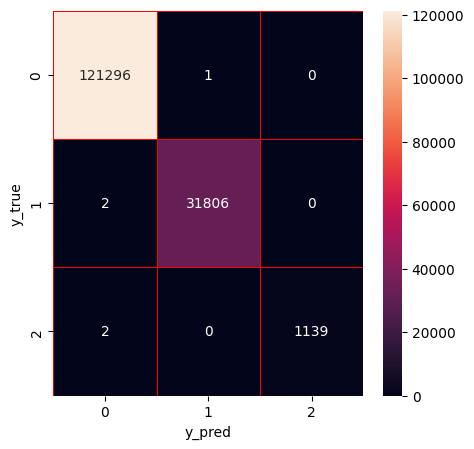

In [8]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### ET

Training time:  10.994422197341919
Prediction time:  0.0012274431341140178 ms
Cross-Validation scores:  [0.9999511  0.99999511 0.99997555]
Mean of Cross-Validation scores:  0.9999739225133969
Accuracy of ET: 0.9999870336994152
Precision of ET: 0.9999870339132061
Recall of ET: 0.9999870336994152
F1-score of ET: 0.999987032280787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



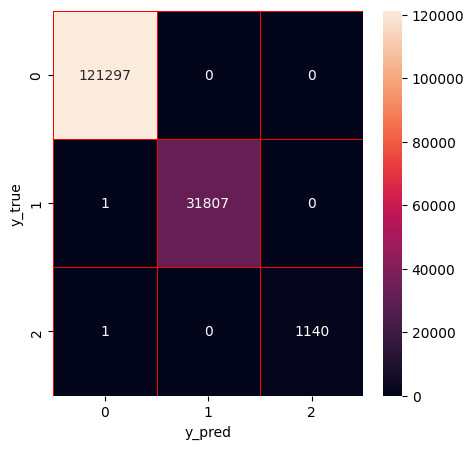

In [9]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### XGBoost

Training time:  6.080761432647705
Prediction time per sample:  0.00044537281814768494
Cross-Validation scores:  [0.99928613 0.99998533 0.99998044]
Mean of Cross-Validation scores:  0.9997506343835076
Accuracy of XGBoost: 0.9999740673988304
Precision of XGBoost: 0.9999740675156886
Recall of XGBoost: 0.9999740673988304
F1-score of XGBoost: 0.999974065931738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



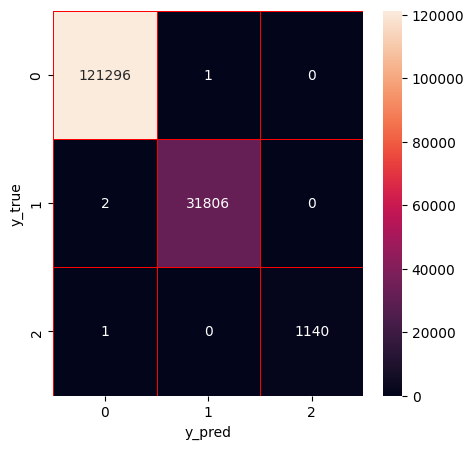

In [10]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16461
[LightGBM] [Info] Number of data points in the train set: 409037, number of used features: 81
[LightGBM] [Info] Start training from score -0.522429
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.273623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

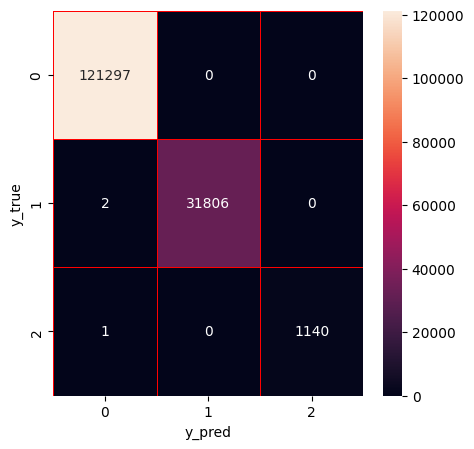

In [11]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


#### Catboost

In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, verbose=False, thread_count=8)
cat_scores = cross_val_score(cat, X_train_balanced, y_train_balanced, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train_balanced, y_train_balanced)
end = time.time()
print('Training time: ', end - start)


Training time:  86.5781626701355


Prediction time per sample:  0.00040765610751235416
Cross-Validation scores:  [0.99937414 0.99998533 0.99998044]
Mean of Cross-Validation scores:  0.9997799715111095
Accuracy of CatBoost: 0.9999740673988304
Precision of CatBoost: 0.9999740675156886
Recall of CatBoost: 0.9999740673988304
F1-score of CatBoost: 0.999974065931738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



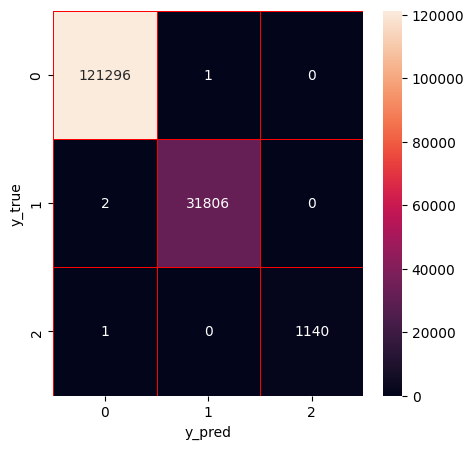

In [13]:
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val) * 1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [14]:
# record the results
dt_train=dt.predict(X_train_balanced)
dt_val=dt.predict(X_val)
dt_prob_train=dt.predict_proba(X_train_balanced)
dt_prob_val=dt.predict_proba(X_val)

rf_train=rf.predict(X_train_balanced)
rf_val=rf.predict(X_val)
rf_prob_train=rf.predict_proba(X_train_balanced)
rf_prob_val=rf.predict_proba(X_val)

et_train=et.predict(X_train_balanced)
et_val=et.predict(X_val)
et_prob_train=et.predict_proba(X_train_balanced)
et_prob_val=et.predict_proba(X_val)

xg_train=xg.predict(X_train_balanced)
xg_val=xg.predict(X_val)
xg_prob_train=xg.predict_proba(X_train_balanced)
xg_prob_val=xg.predict_proba(X_val)

lgbm_train=lgbm.predict(X_train_balanced)
lgbm_val=lgbm.predict(X_val)
lgbm_prob_train=lgbm.predict_proba(X_train_balanced)
lgbm_prob_val=lgbm.predict_proba(X_val)

cat_train=cat.predict(X_train_balanced)
cat_val=cat.predict(X_val)
cat_prob_train=cat.predict_proba(X_train_balanced)
cat_prob_val=cat.predict_proba(X_val)

In [15]:
MODEL_OUTPUT_PREFS = "./models2/prefs"

In [16]:
import joblib

joblib.dump(dt, f"{MODEL_OUTPUT_PREFS}/dt.pkl")
joblib.dump(rf, f"{MODEL_OUTPUT_PREFS}/rf.pkl")
joblib.dump(et, f"{MODEL_OUTPUT_PREFS}/et.pkl")
joblib.dump(xg, f"{MODEL_OUTPUT_PREFS}/xg.pkl")
joblib.dump(lgbm, f"{MODEL_OUTPUT_PREFS}/lgbm.pkl")
joblib.dump(cat, f"{MODEL_OUTPUT_PREFS}/cat.pkl")

['./models2/prefs/cat.pkl']

In [17]:
import gc
gc.collect()

5698

## Model selection

In [18]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)
}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]

In [19]:
top_3_models

['et', 'rf', 'cat']

## Model Ensemble

In [20]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)

dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

Training time of Stacking: 1.4386687278747559
Testing time of Stacking: 9.671466679450207e-05
Accuracy of Stacking: 0.9999870336994152
Precision of Stacking: 0.9999870339132061
Recall of Stacking: 0.9999870336994152
F1-score of Stacking: 0.999987032280787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



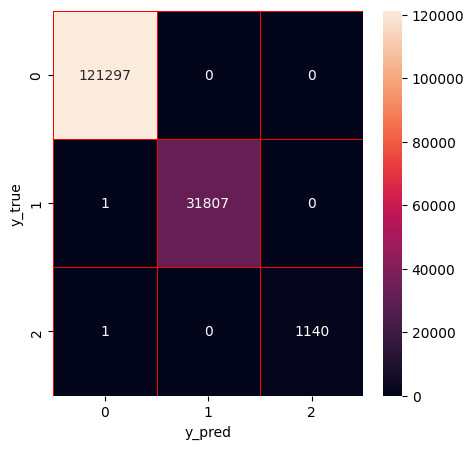

In [21]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0, n_jobs=8).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Training time of Stacking: 2.576942205429077
Testing time of Stacking: 7.569000804847655e-05
Accuracy of Stacking: 0.9998379212426902
Precision of Stacking: 0.9998379546411582
Recall of Stacking: 0.9998379212426902
F1-score of Stacking: 0.9998377468909994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      0.99      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



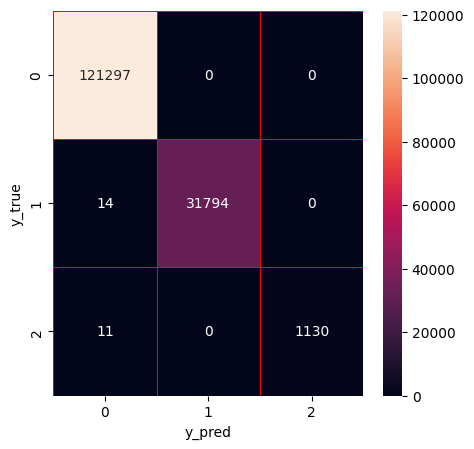

In [22]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Training time of Stacking: 3.3257646560668945
Testing time of Stacking: 0.0001595552418069758
Accuracy of Stacking: 0.9999027527456141
Precision of Stacking: 0.9999027647700536
Recall of Stacking: 0.9999027527456141
F1-score of Stacking: 0.999902744341344
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



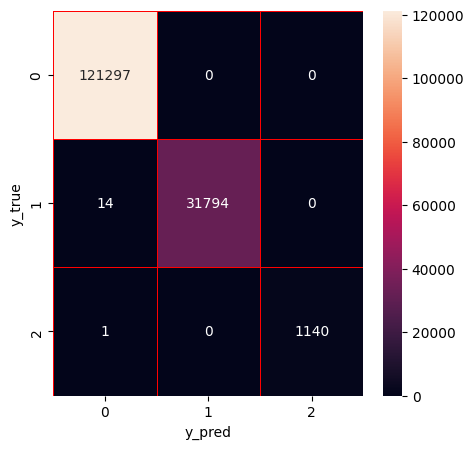

In [23]:
# Ensemble method 3: hybrid stacking

# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
# calcualte the traning time
start_time = time.time()
#stk = lgb.LGBMClassifier().fit(x_train, y_train)
stk =  xgb.XGBClassifier(random_state=0).fit(x_train, y_train_balanced)
end_time = time.time()
stk_time = end_time - start_time
print('Training time of Stacking: '+ str(stk_time))

# calcualte the testing time per sample in milliseconds
start_time = time.time()
y_predict=stk.predict(x_val)
end_time = time.time()
stk_time = (end_time - start_time)/len(x_val)*1000
print('Testing time of Stacking: '+ str(stk_time))

y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Automated Feature Selection

In [24]:
# Save the feature importance lists generated by base ML algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xg_feature = xg.feature_importances_
lgbm_feature = lgbm.feature_importances_
cat_feature = cat.feature_importances_

In [25]:
lgbm_feature = lgbm_feature/sum(lgbm_feature)
cat_feature = cat_feature/sum(cat_feature)

In [26]:
# Get the feature importances of the top-3 models
top_3_importances = [globals()[model.lower() + '_feature'] for model in top_3_models]

# Calculate the average importance of each feature
avg_feature = np.mean(top_3_importances, axis=0)

feature=X_train_balanced.columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)


Features sorted by their score:
[(0.0643, 'Fwd Seg Size Min'), (0.0602, 'Bwd RST Flags'), (0.051, 'Flow Duration'), (0.0507, 'Bwd Segment Size Avg'), (0.0431, 'Bwd Act Data Pkts'), (0.0384, 'Protocol'), (0.0356, 'Bwd Packet Length Max'), (0.0304, 'Flow IAT Max'), (0.0268, 'Fwd IAT Min'), (0.0252, 'Bwd Packet Length Mean'), (0.0247, 'Fwd IAT Total'), (0.0227, 'RST Flag Count'), (0.0208, 'Average Packet Size'), (0.0203, 'Bwd Init Win Bytes'), (0.0201, 'FWD Init Win Bytes'), (0.0199, 'Total Length of Bwd Packet'), (0.0194, 'Packet Length Mean'), (0.0194, 'Fwd IAT Max'), (0.0185, 'FIN Flag Count'), (0.0181, 'Down/Up Ratio'), (0.0175, 'Fwd Packet Length Max'), (0.0167, 'Flow IAT Mean'), (0.0153, 'Packet Length Max'), (0.0151, 'Fwd IAT Mean'), (0.0145, 'Fwd Packets/s'), (0.0144, 'Flow IAT Min'), (0.0138, 'SYN Flag Count'), (0.0133, 'Total Length of Fwd Packet'), (0.0126, 'Fwd Packet Length Mean'), (0.012, 'Packet Length Std'), (0.0118, 'Bwd IAT Min'), (0.0115, 'ACK Flag Count'), (0.0091, 'Id

In [27]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break        

In [28]:
X_train_fs = X_train_balanced[fs]
X_val_fs = X_val[fs]

In [29]:
X_train_fs.to_csv(f"{CHECKPOINT_OUTPUT}/X_train_fs.csv", index=False)
X_val_fs.reset_index().to_csv(f"{CHECKPOINT_OUTPUT}/X_val_fs.csv", index=False)

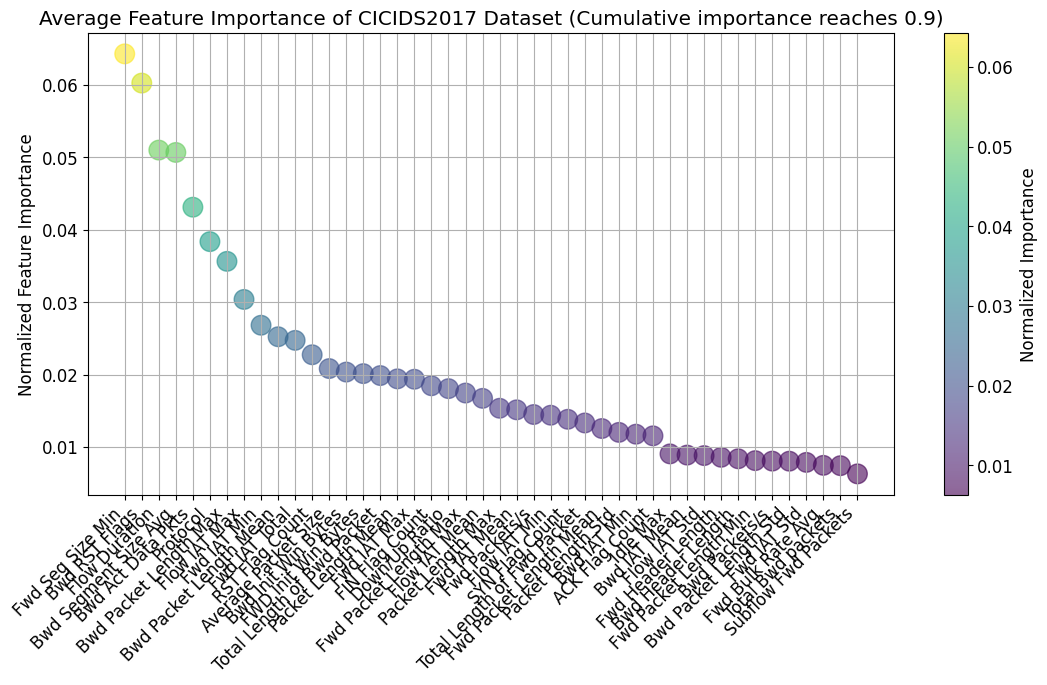

In [32]:
# Plot the feature importance of the top-3 models
plt.rcParams.update({'font.size': 12})

# Create a DataFrame for easier plotting
features = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Importance': avg_feature
})

# Sort features by importance
features = features.sort_values(by='Importance', ascending=False)

# Calculate cumulative importance and filter features
features['Cumulative'] = features['Importance'].cumsum()
filtered_features = features[features['Cumulative'] <= 0.9]

# Plotting
plt.figure(figsize=(13, 6))
scatter = plt.scatter(x='Feature', y='Importance', s=200, c='Importance', cmap='viridis', alpha=0.6, data=filtered_features)
plt.colorbar(scatter, label='Normalized Importance')
plt.xticks(rotation=45, ha='right')
plt.title('Average Feature Importance of CICIDS2017 Dataset (Cumulative importance reaches 0.9)')
plt.ylabel('Normalized Feature Importance')
plt.grid(True)
plt.show()

In [33]:
print(fs)

['Fwd Seg Size Min', 'Bwd RST Flags', 'Flow Duration', 'Bwd Segment Size Avg', 'Bwd Act Data Pkts', 'Protocol', 'Bwd Packet Length Max', 'Flow IAT Max', 'Fwd IAT Min', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'RST Flag Count', 'Average Packet Size', 'Bwd Init Win Bytes', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Packet Length Mean', 'Fwd IAT Max', 'FIN Flag Count', 'Down/Up Ratio', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Packet Length Max', 'Fwd IAT Mean', 'Fwd Packets/s', 'Flow IAT Min', 'SYN Flag Count', 'Total Length of Fwd Packet', 'Fwd Packet Length Mean', 'Packet Length Std', 'Bwd IAT Min', 'ACK Flag Count', 'Idle Max', 'Bwd IAT Mean', 'Flow IAT Std', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Fwd Bulk Rate Avg', 'Total Bwd packets', 'Subflow Fwd Packets', 'Bwd IAT Max']


# Testing

## Machine learning model training

### Training six base learners: 
decision tree, random forest, extra trees, XGBoost, LightGBM, and CatBoost


### Cross-validation

In [34]:
POST_FS_MODEL_OUTPUT = "./models2/postfs"

### DT

Training time:  18.79429817199707
Prediction time per sample:  0.00014740755815126233
Cross-Validation scores:  [0.99769704 0.99983376 0.99986309]
Mean of Cross-Validation scores:  0.9991312948317642
Accuracy of DT: 0.9999027527456141
Precision of DT: 0.999903258218279
Recall of DT: 0.9999027527456141
F1-score of DT: 0.9999028910116893
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



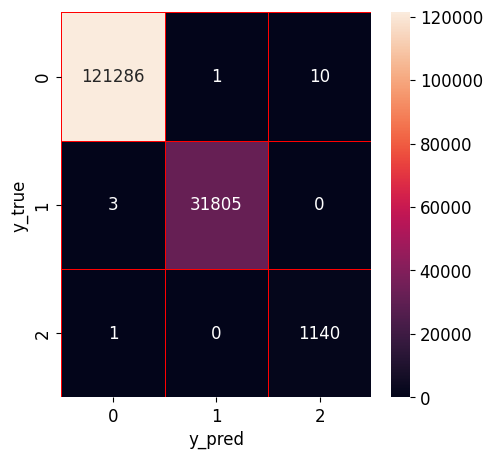

In [35]:
# %%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt


# Decision tree training and prediction with 3-fold cross-validation
dt = DecisionTreeClassifier(random_state=0)
dt_scores = cross_val_score(dt, X_train_fs, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
dt.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs)*1000)

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', dt_scores)
print('Mean of Cross-Validation scores: ', np.mean(dt_scores))

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [36]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt_untuned.pkl")

['./models2/postfs/dt_untuned.pkl']

100%|██████████| 20/20 [02:50<00:00,  8.54s/trial, best loss: -0.9991720409060757]
Decision Tree: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 21, 'min_samples_leaf': 2, 'min_samples_split': 9}
Accuracy of DT: 0.9999222021964913
Precision of DT: 0.9999223373358245
Recall of DT: 0.9999222021964913
F1-score of DT: 0.9999222459095529
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       0.99      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



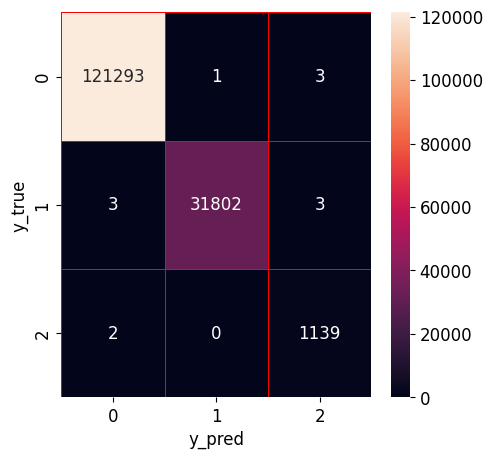

In [37]:
# Hyperparameter Optimization using BO-TPE

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = DecisionTreeClassifier(random_state=0, **params)
    score = cross_val_score(clf, X_train_fs, y_train_balanced, n_jobs=8, scoring='accuracy', cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['max_depth'] = int(best['max_depth'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Decision Tree: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
dt = DecisionTreeClassifier(random_state=0, **best)
dt.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = dt.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
dt_score = dt.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [38]:
joblib.dump(dt, f"{POST_FS_MODEL_OUTPUT}/dt.pkl")

['./models2/postfs/dt.pkl']

### RF

Training time:  20.18659734725952
Prediction time:  0.0010287707743180943 ms
Cross-Validation scores:  [0.99989732 0.99998533 0.99999511]
Mean of Cross-Validation scores:  0.9999592539814728
Accuracy of RF: 0.9999805505491228
Precision of RF: 0.999980550656019
Recall of RF: 0.9999805505491228
F1-score of RF: 0.9999805491680889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



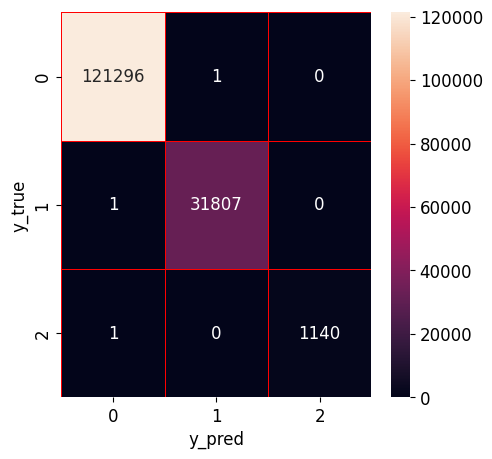

In [39]:
# %%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Random Forest training and prediction with 3-fold cross-validation
rf = RandomForestClassifier(random_state=0, n_jobs=8)
rf_scores = cross_val_score(rf, X_train_fs, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
rf.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', rf_scores)
print('Mean of Cross-Validation scores: ', np.mean(rf_scores))

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [40]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf_untuned.pkl")

['./models2/postfs/rf_untuned.pkl']

100%|██████████| 20/20 [32:04<00:00, 96.24s/trial, best loss: -0.9999543644123906]
Random Forest: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 26, 'max_features': 17, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 142}
Accuracy of RF: 0.9999611010982457
Precision of RF: 0.9999611017595131
Recall of RF: 0.9999611010982457
F1-score of RF: 0.9999610953243022
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



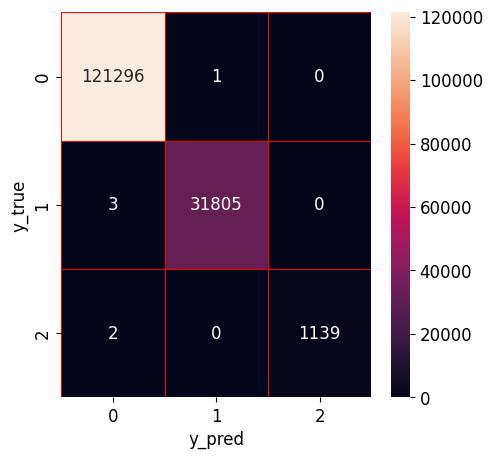

In [41]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = RandomForestClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_fs, y_train_balanced, scoring='accuracy', cv=StratifiedKFold(n_splits=3), n_jobs=8).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 40, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Random Forest: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
rf = RandomForestClassifier(random_state=0, **best)
rf.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = rf.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
rf_score = rf.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [42]:
joblib.dump(rf, f"{POST_FS_MODEL_OUTPUT}/rf.pkl")

['./models2/postfs/rf.pkl']

In [43]:
import gc
gc.collect()

16978

### ET

Training time:  8.245261669158936
Prediction time:  0.0011231158776765092 ms
Cross-Validation scores:  [0.9999511  0.99999022 0.99997555]
Mean of Cross-Validation scores:  0.9999722926729745
Accuracy of ET: 0.9999870336994152
Precision of ET: 0.9999870339132061
Recall of ET: 0.9999870336994152
F1-score of ET: 0.999987032280787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



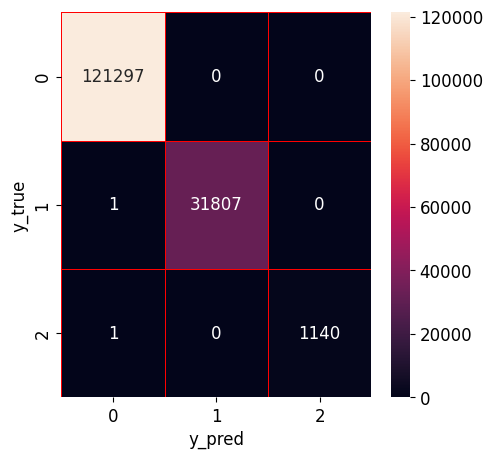

In [44]:
# %%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Extra Trees training and prediction with 3-fold cross-validation
et = ExtraTreesClassifier(random_state=0, n_jobs=8)
et_scores = cross_val_score(et, X_train_fs, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
et.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_val_fs)
end = time.time()
print('Prediction time: ', (end - start) / len(X_val_fs) * 1000, 'ms')


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', et_scores)
print('Mean of Cross-Validation scores: ', np.mean(et_scores))

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [45]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et_untuned.pkl")

['./models2/postfs/et_untuned.pkl']

100%|██████████| 20/20 [07:39<00:00, 22.97s/trial, best loss: -0.9999690330000991]
Extra Trees: Hyperopt estimated optimum {'criterion': 'entropy', 'max_depth': 38, 'max_features': 11, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 147}
Accuracy of ET: 0.9999870336994152
Precision of ET: 0.9999870339132061
Recall of ET: 0.9999870336994152
F1-score of ET: 0.999987032280787
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



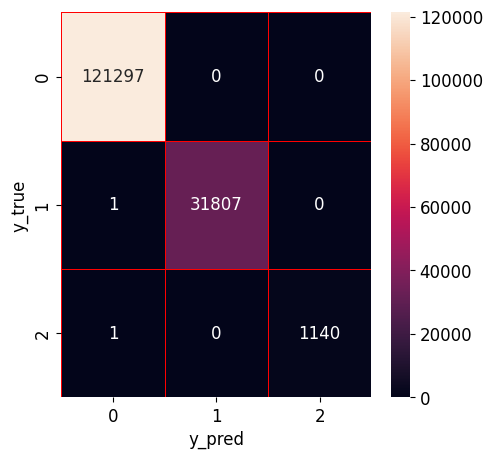

In [46]:
# Hyperparameter Optimization using BO-TPE

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf']),
        'criterion': ['gini', 'entropy'][int(params['criterion'])]
    }
    clf = ExtraTreesClassifier(random_state=0, n_jobs=8, **params)
    score = cross_val_score(clf, X_train_fs, y_train_balanced, scoring='accuracy', n_jobs=8, cv=StratifiedKFold(n_splits=3)).mean()

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 1, 50, 1),
    'max_features': hp.quniform('max_features', 1, 20, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 11, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 11, 1),
    'criterion': hp.choice('criterion', [0, 1])  # 0 for 'gini', 1 for 'entropy'
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['max_features'] = int(best['max_features'])
best['min_samples_split'] = int(best['min_samples_split'])
best['min_samples_leaf'] = int(best['min_samples_leaf'])
best['criterion'] = ['gini', 'entropy'][int(best['criterion'])]

print("Extra Trees: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
et = ExtraTreesClassifier(random_state=0, **best)
et.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = et.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
et_score = et.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [47]:
joblib.dump(et, f"{POST_FS_MODEL_OUTPUT}/et.pkl")

['./models2/postfs/et.pkl']

In [48]:
import gc
gc.collect()

11315

### XGBoost

Training time:  3.8514368534088135
Prediction time per sample:  0.00037443739400619077
Cross-Validation scores:  [0.99912478 0.99997555 0.99999511]
Mean of Cross-Validation scores:  0.9996984795139009
Accuracy of XGBoost: 0.9999740673988304
Precision of XGBoost: 0.9999740675156886
Recall of XGBoost: 0.9999740673988304
F1-score of XGBoost: 0.999974065931738
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



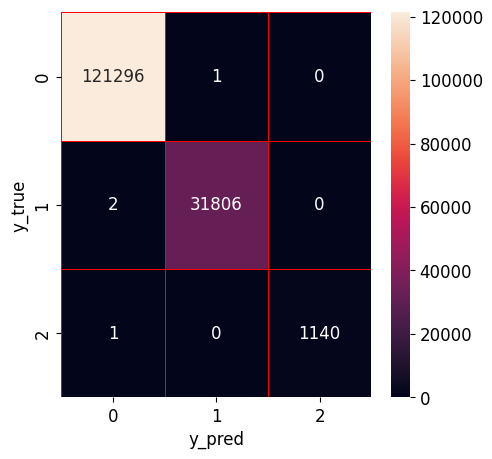

In [49]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# XGBoost training and prediction with 3-fold cross-validation
xg = xgb.XGBClassifier(random_state=0, n_jobs=8)
xg_scores = cross_val_score(xg, X_train_fs, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
xg.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)


y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', xg_scores)
print('Mean of Cross-Validation scores: ', np.mean(xg_scores))

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [50]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg_untuned.pkl")

['./models2/postfs/xg_untuned.pkl']

100%|██████████| 20/20 [00:48<00:00,  2.43s/trial, best loss: -0.9999805505491228]
XGBoost: Hyperopt estimated optimum {'learning_rate': 0.2063937169042234, 'max_depth': 42, 'n_estimators': 90}
Accuracy of XGBoost: 0.9999805505491228
Precision of XGBoost: 0.9999805510301479
Recall of XGBoost: 0.9999805505491228
F1-score of XGBoost: 0.9999805490444326
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



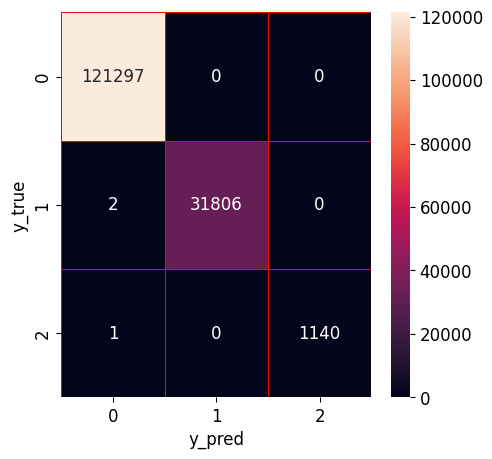

In [51]:
# Hyperparameter Optimization using BO-TPE

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate']))
    }
    clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))

print("XGBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
xg = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0, **best)
xg.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = xg.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
xg_score = xg.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XGBoost: ' + str(xg_score))
print('Precision of XGBoost: ' + str(precision))
print('Recall of XGBoost: ' + str(recall))
print('F1-score of XGBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [52]:
joblib.dump(xg, f"{POST_FS_MODEL_OUTPUT}/xg.pkl")

['./models2/postfs/xg.pkl']

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9822
[LightGBM] [Info] Number of data points in the train set: 409037, number of used features: 45
[LightGBM] [Info] Start training from score -0.522429
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380728
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if 

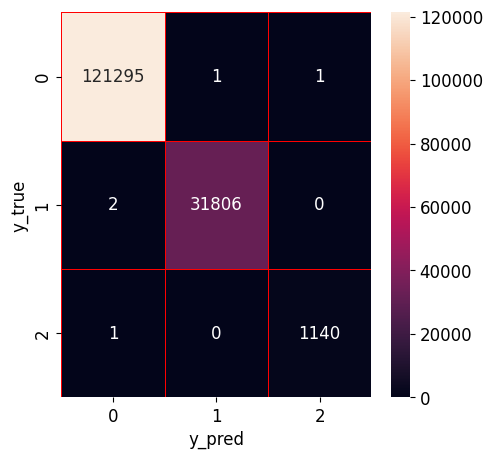

In [53]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# LightGBM training and prediction with 3-fold cross-validation
lgbm = lgb.LGBMClassifier(random_state=0, n_jobs=8)
lgbm_scores = cross_val_score(lgbm, X_train_fs, y_train_balanced, cv=3, n_jobs=8)

# calculate the training time
start = time.time()
lgbm.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)



y_true = y_val

# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', lgbm_scores)
print('Mean of Cross-Validation scores: ', np.mean(lgbm_scores))

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [54]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm_untuned.pkl")

['./models2/postfs/lgbm_untuned.pkl']

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9811                     
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 45
[LightGBM] [Info] Start training from score -0.522428 
[LightGBM] [Info] Start training from score -1.860941 
[LightGBM] [Info] Start training from score -1.380729 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

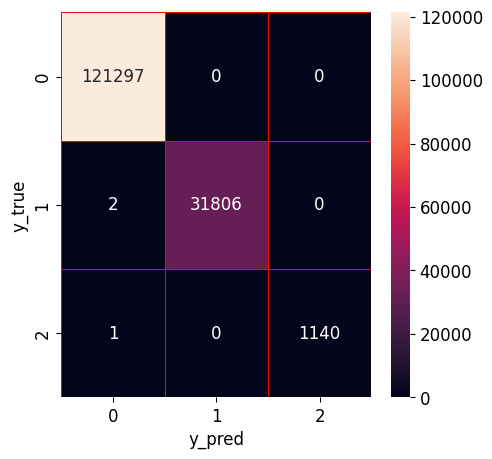

In [55]:
# Hyperparameter Optimization using BO-TPE

import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'learning_rate': abs(float(params['learning_rate'])),
        'num_leaves': int(params['num_leaves']),
        'min_child_samples': int(params['min_child_samples'])
    }
    clf = lgb.LGBMClassifier(random_state=0, n_jobs=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
    'num_leaves': hp.quniform('num_leaves', 10, 200, 5),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['learning_rate'] = abs(float(best['learning_rate']))
best['num_leaves'] = int(best['num_leaves'])
best['min_child_samples'] = int(best['min_child_samples'])

print("LightGBM: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
lgbm = lgb.LGBMClassifier(random_state=0, **best)
lgbm.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = lgbm.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
lgbm_score = lgbm.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LightGBM: ' + str(lgbm_score))
print('Precision of LightGBM: ' + str(precision))
print('Recall of LightGBM: ' + str(recall))
print('F1-score of LightGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [56]:
joblib.dump(lgbm, f"{POST_FS_MODEL_OUTPUT}/lgbm.pkl")

['./models2/postfs/lgbm.pkl']

### CatBoost

Training time:  62.885993003845215
Prediction time per sample:  0.0003840980407612753
Cross-Validation scores:  [0.99988754 0.99998044 0.99997555]
Mean of Cross-Validation scores:  0.9999478450666398
Accuracy of CatBoost: 0.9999805505491228
Precision of CatBoost: 0.9999805510301479
Recall of CatBoost: 0.9999805505491228
F1-score of CatBoost: 0.9999805490444326
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



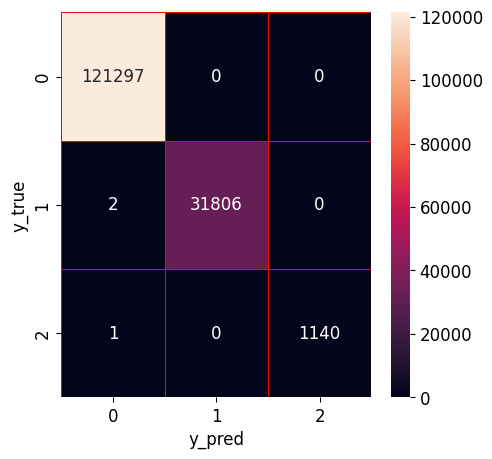

In [57]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# CatBoost training and prediction with 3-fold cross-validation
cat = CatBoostClassifier(random_state=0, thread_count=8, verbose=False)
cat_scores = cross_val_score(cat, X_train_fs, y_train_balanced, cv=3, n_jobs=8)


# calculate the training time
start = time.time()
cat.fit(X_train_fs, y_train_balanced)
end = time.time()
print('Training time: ', end - start)

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_val_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_val_fs) * 1000)


# Print out the cross-validation scores and mean of them
print('Cross-Validation scores: ', cat_scores)
print('Mean of Cross-Validation scores: ', np.mean(cat_scores))

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [58]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat_untuned.pkl")

['./models2/postfs/cat_untuned.pkl']

100%|██████████| 20/20 [26:18<00:00, 78.93s/trial, best loss: -0.9999805505491228] 
CatBoost: Hyperopt estimated optimum {'depth': 7, 'iterations': 600, 'learning_rate': 0.4458966015911379}
Accuracy of CatBoost: 0.9999805505491228
Precision of CatBoost: 0.9999805510301479
Recall of CatBoost: 0.9999805505491228
F1-score of CatBoost: 0.9999805490444326
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121297
           1       1.00      1.00      1.00     31808
           2       1.00      1.00      1.00      1141

    accuracy                           1.00    154246
   macro avg       1.00      1.00      1.00    154246
weighted avg       1.00      1.00      1.00    154246



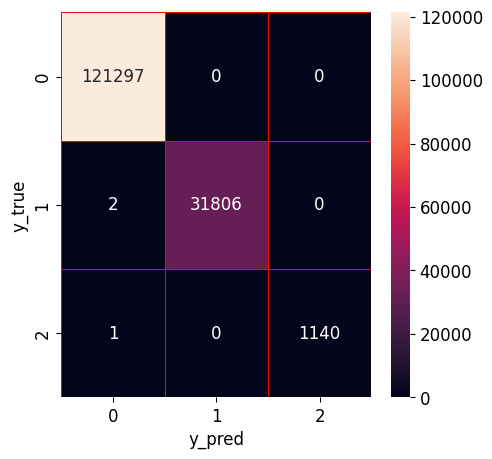

In [59]:
# Hyperparameter Optimization using BO-TPE

import catboost as cb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the objective function
def objective(params):
    params = {
        'depth': int(params['depth']),
        'learning_rate': params['learning_rate'],
        'iterations': int(params['iterations'])
    }
    clf = cb.CatBoostClassifier(random_state=0, verbose=False, thread_count=8, **params)
    clf.fit(X_train_fs, y_train_balanced)
    y_pred = clf.predict(X_val_fs)
    score = accuracy_score(y_val, y_pred)

    return {'loss': -score, 'status': STATUS_OK }

# Define the hyperparameter configuration space
space = {
    'depth': hp.quniform('depth', 2, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'iterations': hp.quniform('iterations', 100, 1000, 100)
}

# Run the optimizer
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)

# Convert the returned hyperparameters to their original types
best['depth'] = int(best['depth'])
best['learning_rate'] = best['learning_rate']
best['iterations'] = int(best['iterations'])

print("CatBoost: Hyperopt estimated optimum {}".format(best))

# Use the best parameters to train the model
cat = cb.CatBoostClassifier(random_state=0, verbose=False, **best)
cat.fit(X_train_fs, y_train_balanced)

# Make predictions
y_predict = cat.predict(X_val_fs)
y_true = y_val

# Evaluation metrics
cat_score = cat.score(X_val_fs, y_val)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of CatBoost: ' + str(cat_score))
print('Precision of CatBoost: ' + str(precision))
print('Recall of CatBoost: ' + str(recall))
print('F1-score of CatBoost: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [60]:
joblib.dump(cat, f"{POST_FS_MODEL_OUTPUT}/cat.pkl")

['./models2/postfs/cat.pkl']

In [61]:
# record the results
dt_train=dt.predict(X_train_fs)
dt_val=dt.predict(X_val_fs)
dt_prob_train=dt.predict_proba(X_train_fs)
dt_prob_val=dt.predict_proba(X_val_fs)

rf_train=rf.predict(X_train_fs)
rf_val=rf.predict(X_val_fs)
rf_prob_train=rf.predict_proba(X_train_fs)
rf_prob_val=rf.predict_proba(X_val_fs)

et_train=et.predict(X_train_fs)
et_val=et.predict(X_val_fs)
et_prob_train=et.predict_proba(X_train_fs)
et_prob_val=et.predict_proba(X_val_fs)

xg_train=xg.predict(X_train_fs)
xg_val=xg.predict(X_val_fs)
xg_prob_train=xg.predict_proba(X_train_fs)
xg_prob_val=xg.predict_proba(X_val_fs)

lgbm_train=lgbm.predict(X_train_fs)
lgbm_val=lgbm.predict(X_val_fs)
lgbm_prob_train=lgbm.predict_proba(X_train_fs)
lgbm_prob_val=lgbm.predict_proba(X_val_fs)

cat_train=cat.predict(X_train_fs)
cat_val=cat.predict(X_val_fs)
cat_prob_train=cat.predict_proba(X_train_fs)
cat_prob_val=cat.predict_proba(X_val_fs)

## Model selection

In [62]:
# Calculate the performance of each base model (e.g., accuracy)
base_model_performance = {
    'dt': np.mean(dt_scores),
    'rf': np.mean(rf_scores),
    'et': np.mean(et_scores),
    'xg': np.mean(xg_scores),
    'lgbm': np.mean(lgbm_scores),
    'cat': np.mean(cat_scores)

}

# Rank the base models based on their performance
ranked_models = sorted(base_model_performance, key=base_model_performance.get, reverse=True)

# Select the top-3 performing base models
top_3_models = ranked_models[:3]



In [63]:
top_3_models

['et', 'rf', 'cat']

In [64]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
lgbm_train=lgbm_train.reshape(-1, 1)
cat_train=cat_train.reshape(-1, 1)


dt_val=dt_val.reshape(-1, 1)
et_val=et_val.reshape(-1, 1)
rf_val=rf_val.reshape(-1, 1)
xg_val=xg_val.reshape(-1, 1)
lgbm_val=lgbm_val.reshape(-1, 1)
cat_val=cat_val.reshape(-1, 1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 3
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

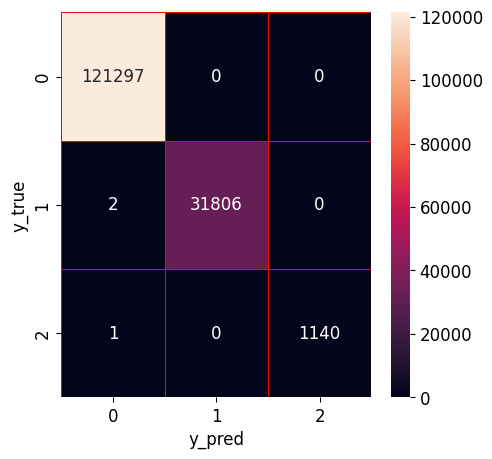

In [65]:
# Ensemble method 1: traditional stacking

# Get the predictions of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

# Stack the predictions of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions, axis=1)
x_val = np.concatenate(top_3_val_predictions, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [66]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")

['./models2/postfs/stk1.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1659
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 9
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

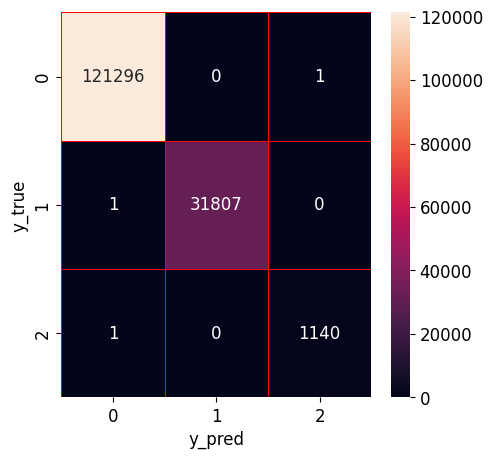

In [67]:
# Ensemble method 2: confidence-based stacking

# Get the prediction probabilities of the top-3 models
top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Stack the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [68]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")

['./models2/postfs/stk2.pkl']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1668
[LightGBM] [Info] Number of data points in the train set: 613556, number of used features: 12
[LightGBM] [Info] Start training from score -0.522428
[LightGBM] [Info] Start training from score -1.860941
[LightGBM] [Info] Start training from score -1.380729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

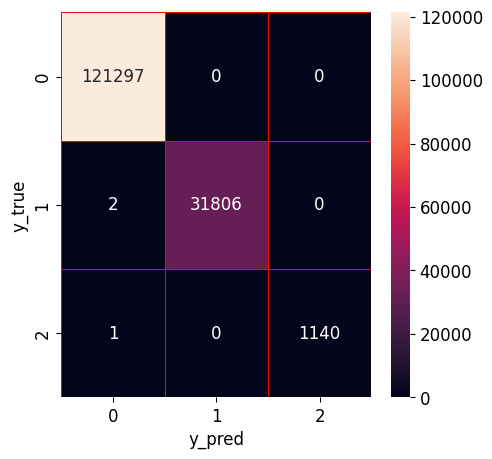

In [69]:
# Ensemble method 3: hybrid stacking
# Get the predictions and prediction probabilities of the top-3 models
top_3_train_predictions = [globals()[model.lower() + '_train'] for model in top_3_models]
top_3_val_predictions = [globals()[model.lower() + '_val'] for model in top_3_models]

top_3_train_proba = [globals()[model.lower() + '_prob_train'] for model in top_3_models]
top_3_val_proba = [globals()[model.lower() + '_prob_val'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_train_balanced = np.concatenate(top_3_train_predictions + top_3_train_proba, axis=1)
x_val = np.concatenate(top_3_val_predictions + top_3_val_proba, axis=1)

# Train and evaluate the stacking model
stk = lgb.LGBMClassifier().fit(x_train_balanced, y_train_balanced)
y_predict=stk.predict(x_val)
y_true=y_val
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

# PS: the hyperparameter optimization process is the same as the previous steps

In [70]:
joblib.dump(stk, f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

['./models2/postfs/stk3.pkl']

# Final Test

In [73]:
df_test = pd.read_csv('../../datasets/output/test_final.csv', parse_dates=['Timestamp'])
df_test

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Idle Max,Idle Min,ICMP Code,ICMP Type,Fwd TCP Retrans. Count,Bwd TCP Retrans. Count,Total TCP Retrans. Count,Total Connection Flow Time,Label,Old Index
0,67fe01c7-f0d3-40ae-9734-11b87bbad3bd,192.168.10.14,51104,93.184.216.180,443,6,2017-07-05 13:05:56.267121,85742.0,10,6,...,0.0,0.0,0,0,0,0,0,85742,Benign,748588
1,8ae50662-7e0b-4ead-8e28-239831b9ef68,192.168.10.51,47817,162.213.33.48,443,6,2017-07-05 13:05:56.893194,1038445.0,10,12,...,0.0,0.0,0,0,0,0,0,1038445,Benign,499043
2,25b06579-d96c-48a0-a51d-7a430954b846,192.168.10.14,51114,178.255.83.1,80,6,2017-07-05 13:05:57.976332,70672.0,5,5,...,0.0,0.0,0,0,1,0,1,70672,Benign,855901
3,9e187a13-ffe2-4a44-8a8c-b624bc5b770d,192.168.10.14,51122,63.251.85.32,443,6,2017-07-05 13:05:58.340753,217279.0,9,11,...,0.0,0.0,0,0,1,0,1,217279,Benign,936128
4,5edd0384-aa65-487b-b9e5-33ebc63cbe0f,192.168.10.14,51121,63.251.85.32,443,6,2017-07-05 13:05:58.340662,219470.0,8,8,...,0.0,0.0,0,0,1,0,1,219470,Benign,708939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153693,9007ea08-91f4-4f7e-88bb-2028c6a83115,192.168.10.50,55577,192.168.10.3,53,17,2017-07-07 19:19:22.247120,150.0,2,2,...,0.0,0.0,0,0,0,0,0,150,Benign,626458
153694,f94bf22a-875b-4e88-ad42-ffae18afde65,192.168.10.50,46067,192.168.10.3,53,17,2017-07-07 19:19:22.246796,195.0,2,2,...,0.0,0.0,0,0,0,0,0,195,Benign,577996
153695,f62720f2-cdfe-4fa3-b54e-530f595e0007,192.168.10.50,60990,192.168.10.3,53,17,2017-07-07 19:19:22.247401,176.0,2,2,...,0.0,0.0,0,0,0,0,0,176,Benign,578218
153696,14f89ec0-bf3e-4168-ac3c-b9177edfbec6,192.168.10.50,46446,192.168.10.3,53,17,2017-07-07 19:19:22.248611,141.0,2,2,...,0.0,0.0,0,0,0,0,0,141,Benign,883240


In [74]:
df_test['Label'].value_counts()

Label
Benign       120752
Portscan      31808
Slowloris      1138
Name: count, dtype: int64

In [79]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Benign', 'Portscan', 'Slowloris'])

array([0, 1, 2])

In [80]:
X_test_fs = df_test.drop('Label', axis=1)[fs]
y_test = labelencoder.transform(df_test['Label'])

In [81]:
# record the results
dt_test_real=dt.predict(X_test_fs)
dt_prob_test_real=dt.predict_proba(X_test_fs)

rf_test_real=rf.predict(X_test_fs)
rf_prob_test_real=rf.predict_proba(X_test_fs)

et_test_real=et.predict(X_test_fs)
et_prob_test_real=et.predict_proba(X_test_fs)

xg_test_real=xg.predict(X_test_fs)
xg_prob_test_real=xg.predict_proba(X_test_fs)

lgbm_test_real=lgbm.predict(X_test_fs)
lgbm_prob_test_real=lgbm.predict_proba(X_test_fs)

cat_test_real=cat.predict(X_test_fs)
cat_prob_test_real=cat.predict_proba(X_test_fs)

In [82]:
dt_test_real=dt_test_real.reshape(-1, 1)
rf_test_real=rf_test_real.reshape(-1, 1)
et_test_real=et_test_real.reshape(-1, 1)
xg_test_real=xg_test_real.reshape(-1, 1)
lgbm_test_real=lgbm_test_real.reshape(-1, 1)
cat_test_real=cat_test_real.reshape(-1, 1)

Prediction time per sample:  0.00017353902913394515 ms
Accuracy of DT: 0.9971047118374995
Precision of DT: 0.9970826425361783
Recall of DT: 0.9971047118374995
F1-score of DT: 0.9968856655680286
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       0.99      0.68      0.81      1138

    accuracy                           1.00    153698
   macro avg       0.99      0.89      0.93    153698
weighted avg       1.00      1.00      1.00    153698



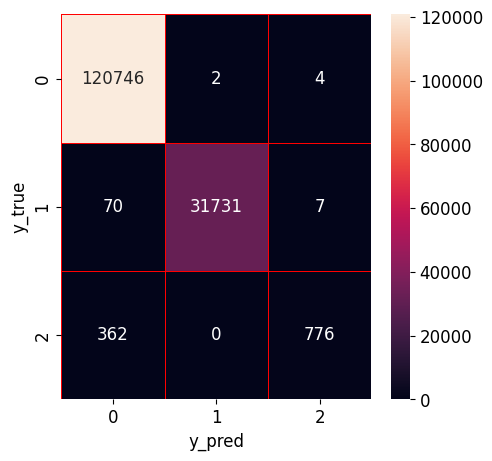

In [88]:
# Decision Tree

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
dt_score = dt.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of DT: ' + str(dt_score))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.002081739278752954 ms
Accuracy of RF: 0.9969485614646905
Precision of RF: 0.9969567247808099
Recall of RF: 0.9969485614646905
F1-score of RF: 0.9966678153283832
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.64      0.78      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.88      0.93    153698
weighted avg       1.00      1.00      1.00    153698



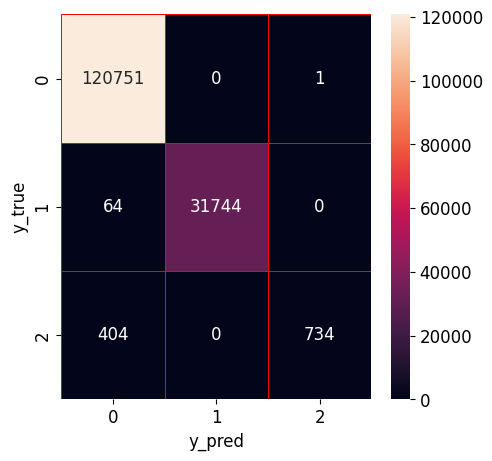

In [90]:
# Random Forest

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
rf_score = rf.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of RF: ' + str(rf_score))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0035705702168550377 ms
Accuracy of ET: 0.9972868872724434
Precision of ET: 0.9972932317197166
Recall of ET: 0.9972868872724434
F1-score of ET: 0.9970770226420791
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.69      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



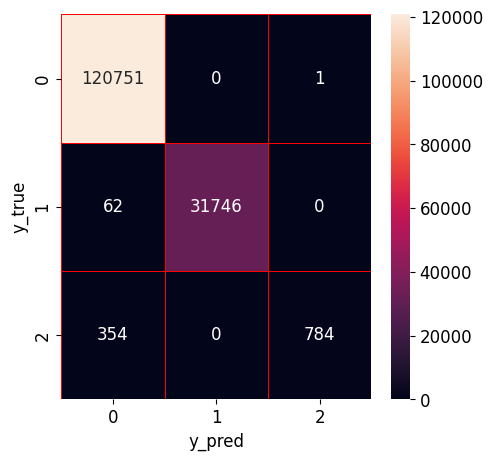

In [91]:
# Extra Trees

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
et_score = et.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of ET: ' + str(et_score))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00047739869788246224 ms
Accuracy of XG: 0.997273874741376
Precision of XG: 0.9972833014728824
Recall of XG: 0.997273874741376
F1-score of XG: 0.9970599842786215
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.69      0.81      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.89      0.94    153698
weighted avg       1.00      1.00      1.00    153698



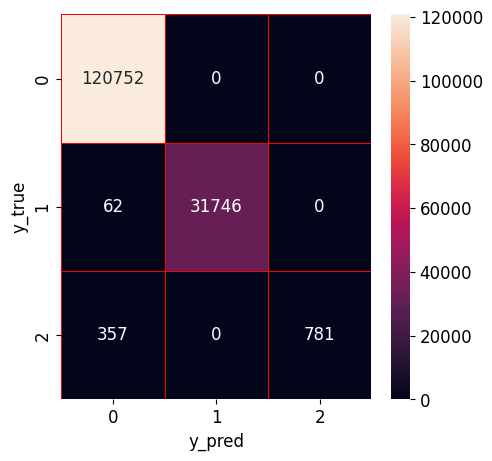

In [92]:
# XGBoost

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
xg_score = xg.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of XG: ' + str(xg_score))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0008796689710421116 ms
Accuracy of LGBM: 0.9974170125831175
Precision of LGBM: 0.9974254769204585
Recall of LGBM: 0.9974170125831175
F1-score of LGBM: 0.9972308453083975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.71      0.83      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



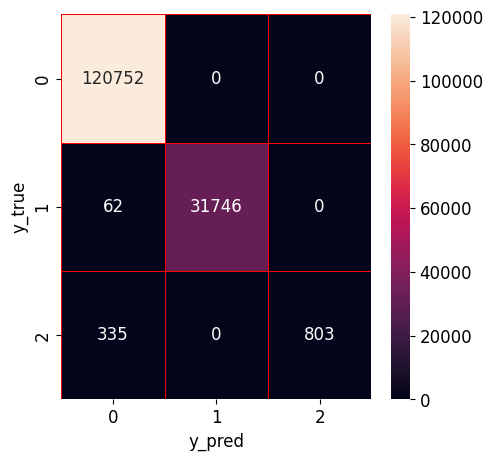

In [93]:
# LightGBM

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
lgbm_score = lgbm.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of LGBM: ' + str(lgbm_score))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0003134601358076822 ms
Accuracy of Cat: 0.9973649624588479
Precision of Cat: 0.9973737707836179
Recall of Cat: 0.9973649624588479
F1-score of Cat: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



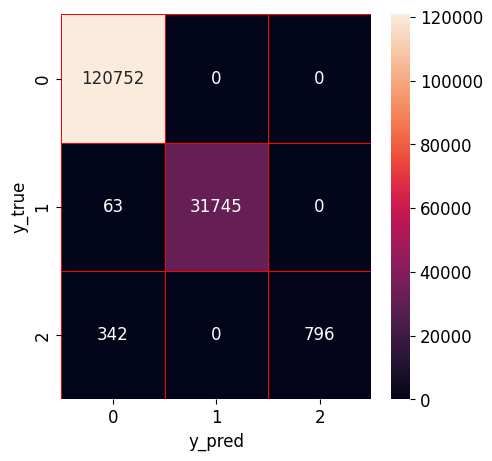

In [94]:
# CatBoost

# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(y_predict) * 1000, 'ms')

y_true = y_test

# Evaluation metrics
cat_score = cat.score(X_test_fs, y_test)
precision, recall, fscore, none = precision_recall_fscore_support(y_true, y_predict, average='weighted')

# Print results
print('Accuracy of Cat: ' + str(cat_score))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true, y_predict))

# Confusion matrix visualization
cm = confusion_matrix(y_true, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [97]:
stk1 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk1.pkl")
stk2 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk2.pkl")
stk3 = joblib.load(f"{POST_FS_MODEL_OUTPUT}/stk3.pkl")

Accuracy of Stacking: 0.9973649624588479
Precision of Stacking: 0.9973737707836179
Recall of Stacking: 0.9973649624588479
F1-score of Stacking: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



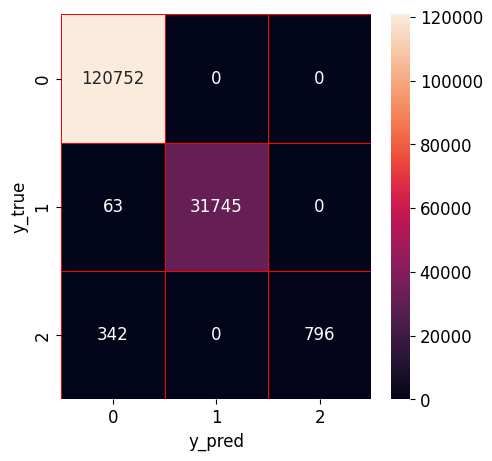

In [102]:
# Ensemble method 1: traditional stacking
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions, axis=1)

y_predict = stk1.predict(x_test_real)
y_true = y_test

stk1_score = accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: '+ str(stk1_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of Stacking: 0.9974430376452523
Precision of Stacking: 0.9974460047980515
Recall of Stacking: 0.9974430376452523
F1-score of Stacking: 0.99726659528209
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.71      0.83      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



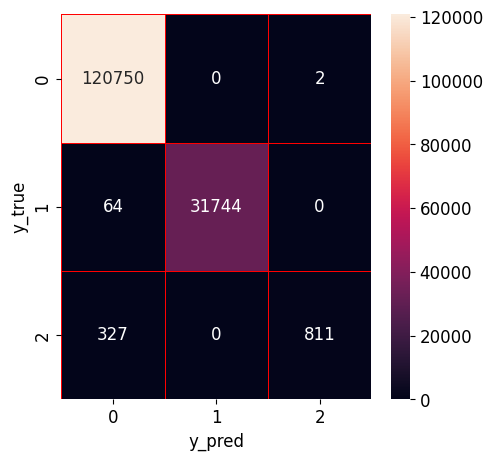

In [103]:
# Ensemble method 2: confidence-based stacking
top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_proba, axis=1)

y_predict = stk2.predict(x_test_real)
y_true = y_test

stk2_score=accuracy_score(y_true, y_predict)
print('Accuracy of Stacking: '+ str(stk2_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Accuracy of Stacking: 0.9973649624588479
Precision of Stacking: 0.9973737707836179
Recall of Stacking: 0.9973649624588479
F1-score of Stacking: 0.9971702228595163
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120752
           1       1.00      1.00      1.00     31808
           2       1.00      0.70      0.82      1138

    accuracy                           1.00    153698
   macro avg       1.00      0.90      0.94    153698
weighted avg       1.00      1.00      1.00    153698



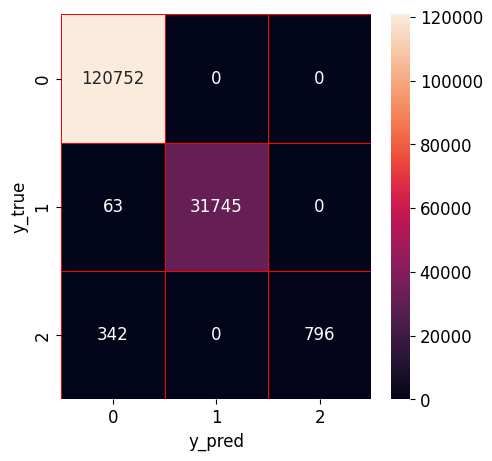

In [104]:
# Ensemble method 1: traditional stacking
top_3_test_real_predictions = [globals()[model.lower() + '_test_real'] for model in top_3_models]
top_3_test_real_proba = [globals()[model.lower() + '_prob_test_real'] for model in top_3_models]

# Combine the predictions and prediction probabilities of the top-3 models
x_test_real = np.concatenate(top_3_test_real_predictions + top_3_test_real_proba, axis=1)

y_predict=stk3.predict(x_test_real)
y_true=y_test

stk3_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk3_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()